<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 5px; height: 70px">

# Optimising Hospital Bed Occupancy through Machine Learning
**DSI-41 Group FWSG**: Muhammad Faaiz Khan, Sharifah Nurulhuda, Tan Wei Chiong, Gabriel Tan

### 03_05 RNN_LSTM

### Overview
___

**RNN-LSTM** stands for **Recurrent Neural Networks - Long-Short Term Memory**.

It is a sequential neural network implemented as a predictive model.

We will integrate autoregression (SARIMA) as part of our LSTM model.


**Visual Example of Our LSTM Architecture**

<img src='../images/LSTM_layers.png' style="float: left; margin: 5px; height: 300px">

### Import Libraries
___

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM
from keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-02-08 22:56:22.848193: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Reading the dataframe to the notebook
df =  pd.read_csv('../datasets/for_timeseries.csv')

In [3]:
df.head()

,date,year,nuh,total_rainfall,wet_bulb_temperature,dengue,urti,diarrhea,is_holiday,day_Mon,...,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,2022-01-01,2022,72.0,25.2,26.0,11.0,904.0,287.0,1,False,...,False,False,True,False,False,False,False,False,False,False
1,2022-01-02,2022,73.7,50.0,24.1,15.0,977.0,297.0,0,False,...,False,False,True,False,False,False,False,False,False,False
2,2022-01-03,2022,78.7,6.0,25.6,15.0,977.0,297.0,0,True,...,False,False,True,False,False,False,False,False,False,False
3,2022-01-04,2022,79.1,4.8,25.8,15.0,977.0,297.0,0,False,...,False,False,True,False,False,False,False,False,False,False
4,2022-01-05,2022,81.8,1.0,26.3,15.0,977.0,297.0,0,False,...,False,False,True,False,False,False,False,False,False,False


In [4]:
# Reformatting the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
# Setting date as the index
df = df.set_index('date').drop(columns='year')
df.head(1)

,nuh,total_rainfall,wet_bulb_temperature,dengue,urti,diarrhea,is_holiday,day_Mon,day_Sat,day_Sun,...,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,72.0,25.2,26.0,11.0,904.0,287.0,1,False,True,False,...,False,False,True,False,False,False,False,False,False,False


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2022-01-01 to 2023-12-31
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   nuh                   730 non-null    float64
 1   total_rainfall        730 non-null    float64
 2   wet_bulb_temperature  730 non-null    float64
 3   dengue                730 non-null    float64
 4   urti                  730 non-null    float64
 5   diarrhea              730 non-null    float64
 6   is_holiday            730 non-null    int64  
 7   day_Mon               730 non-null    bool   
 8   day_Sat               730 non-null    bool   
 9   day_Sun               730 non-null    bool   
 10  day_Thu               730 non-null    bool   
 11  day_Tue               730 non-null    bool   
 12  day_Wed               730 non-null    bool   
 13  month_Aug             730 non-null    bool   
 14  month_Dec             730 non-null    bool   
 15  mont

### Preparing dataframe for Modelling
___

The following steps are performed to prepare the dataframe before modelling:

1. Define target feature y and predictive features X.
2. Scaling the dataframe using `MinMaxScaler`.
3. Perform train-test split.
4. Convert data into an array format using `TimeseriesGenerator`.

We will define `nuh` as our target feature y, and the remaining features as our predictive features X.

The MinMaxScaler is a recommended step before modelling as it both reduces training time and improves prediction ability of the model.

In [6]:
# Defining X and y, then scaling X and y features using MinMaxScaler
nuh_scaler = MinMaxScaler(feature_range=(0, 1))
y_nuh = nuh_scaler.fit_transform(df['nuh'].array.reshape(-1, 1))

X_scaler = MinMaxScaler(feature_range=(0, 1))
X = X_scaler.fit_transform(df[df.columns[3:]])

Note that we set shuffle=False during the `train_test_split` so that the sequential nature of the data is maintained.

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_nuh, test_size=0.2, shuffle=False)

We use `TimeseriesGenerator` to convert our data into batches of length 10. This way, each batch will capture the sequential nature of consecutive datapoints, which is critical for our LSTM model.

In [8]:
# Running TimeseriesGenerator on train and test data
train_sequences = TimeseriesGenerator(X_train, y_train, length=10, batch_size=64)
test_sequences = TimeseriesGenerator(X_test, y_test, length=10, batch_size=64)

# Check shape of X and y batches
batch_x, batch_y = train_sequences[0]
print(batch_x.shape)
print(batch_y.shape)

(64, 10, 21)
(64, 1)


### Generating NUH model
___

We will now proceed to create the LSTM model for NUH.

The model will feature the following permutation of layers:
- 2 `LSTM` layers
- 2 `Dense` layers
- 1 `Dense` output layer

As we are solving a regression problem, we will use the RELU activation function when outputting our result.

In [9]:
# Obtaining shape of train features
input_shape = train_sequences[0][0][0].shape
print(input_shape)

(10, 21)


In [10]:
# Instantiate NUH model and add layers
nuh_model = Sequential()
nuh_model.add(LSTM(8, input_shape=input_shape, return_sequences=True)) # True if next layer is RNN
nuh_model.add(LSTM(8, return_sequences=False)) # False if next layer is Dense

nuh_model.add(Dense(4, activation='relu'))
nuh_model.add(Dense(1, activation='relu'))

2024-02-08 22:56:25.128914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-08 22:56:25.129877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-08 22:56:25.130493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

We will fit the model to the NUH data below. We establish a learning rate of 0.0005 and 50 epochs. These hyperparameters were established through a reiterative empirical process of exploring optimal hyperparameters, to find a model that performs well on the unseen test data.

In [11]:
# Compile and fit NUH model to NUH data
nuh_model.compile(optimizer=Adam(lr=.0005), loss='mean_squared_error')
nuh_history = nuh_model.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)

/Users/hudalhabsyi/anaconda3/envs/myenv/lib/python3.11/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2024-02-08 22:56:25.279137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-08 22:56:25.475126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-08 22:56:25.476226: I tensorflow/core/common_runtime/execu

In [12]:
# Generate NUH model summary
nuh_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 8)             960       
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dense (Dense)               (None, 4)                 36        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1,545
Trainable params: 1,545
Non-trainable params: 0
_________________________________________________________________


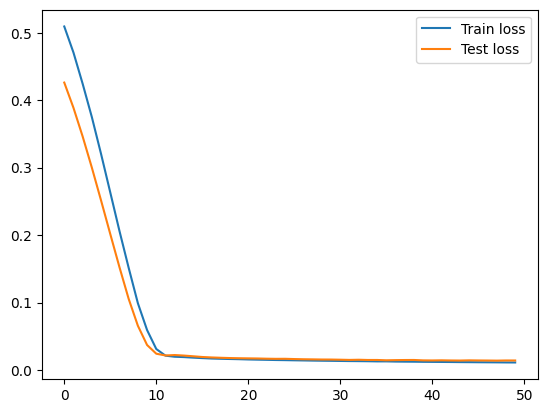

In [13]:
# Check NUH model train vs test loss
plt.plot(nuh_history.history['loss'], label='Train loss')
plt.plot(nuh_history.history['val_loss'], label='Test loss')
plt.legend();

The significance of the train loss and test loss is defined below:
- Train loss: is used to guide the model's learning process on training data.
- Test loss: measure of the model's generalization performance on new, unseen data.

A good assesment for the number of epochs is a intercept/convergence of the train and test loss. We can interpret that our model has been optimised as the train and test losses are minimised and converged at 50 epochs.

In [14]:
length=10
'''
Generating predictions
'''
# Generating prediction values from model
pred = nuh_model.predict(test_sequences)

# Undoing minmaxscaler on the predicted values
pred_it = nuh_scaler.inverse_transform(pred)

# Creating dataframe for predicted values
pred_df = pd.DataFrame(pred_it, columns=['predicted'])

# Set the pred values index to the indexes pertaining to the test values
pred_df.index = range(len(y_train)+length, len(df))

# Appending the predicted values to the original dataframe so we can plot it against time
df_plot = df.reset_index().join(pred_df).set_index('date')


2024-02-08 22:56:31.072050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-08 22:56:31.193209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-08 22:56:31.193917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

3/3 [==============================] - 0s 2ms/step


2024-02-08 22:56:31.295765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-08 22:56:31.297141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-08 22:56:31.297929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

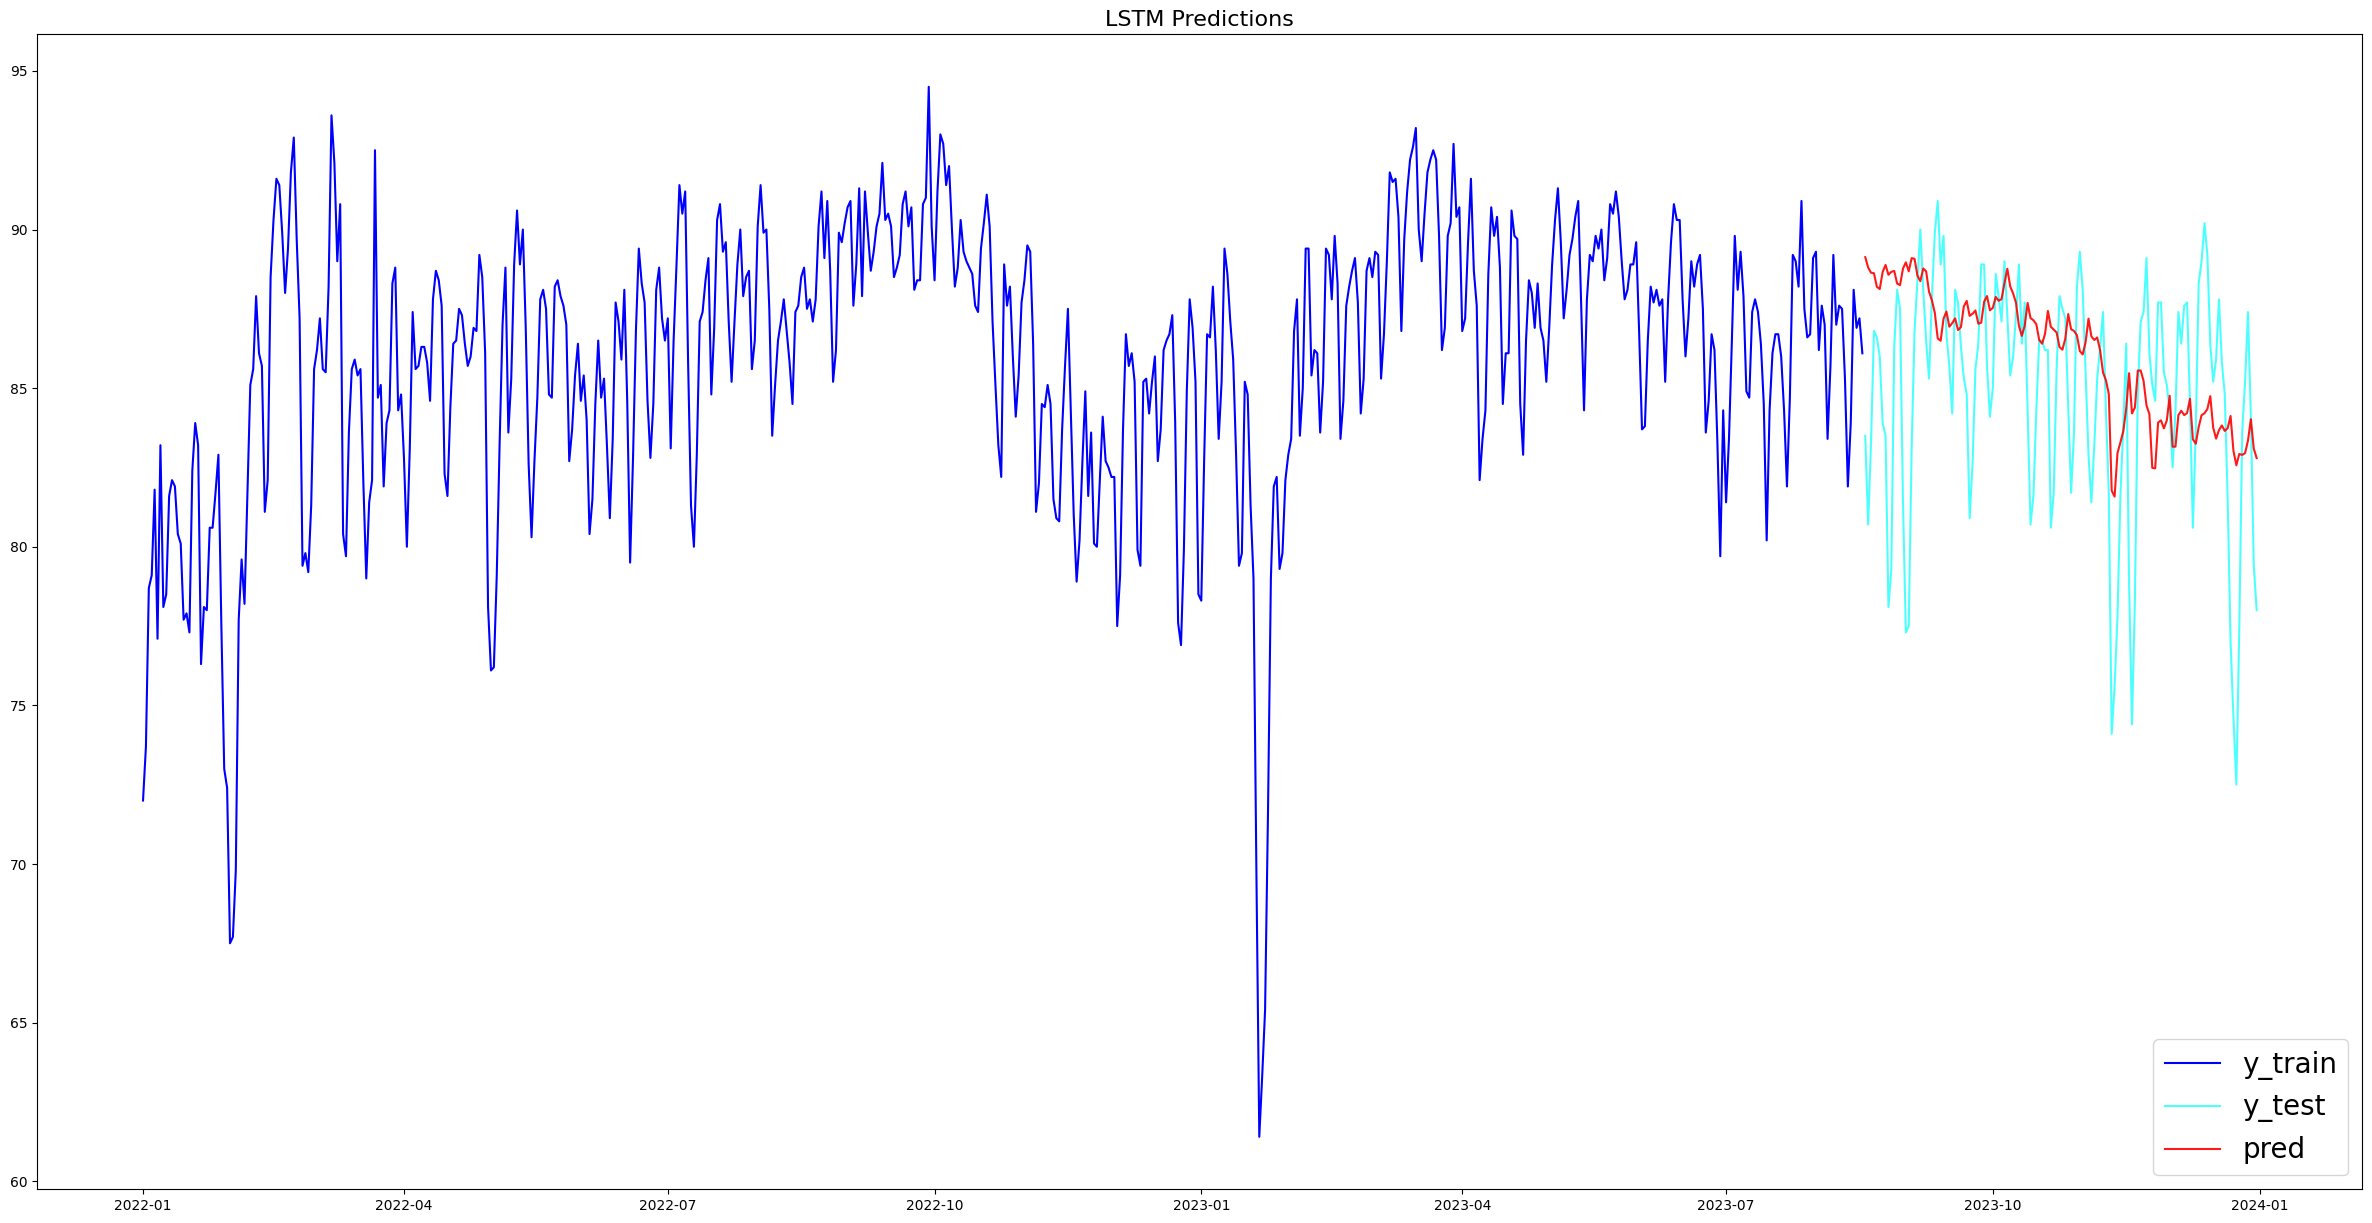

In [15]:

'''
Plotting graphs
'''
plt.figure(figsize=(30,15))

# Plot training data
plt.plot(df_plot['nuh'][:len(y_train)+length], color='blue', label='y_train')

# Plot testing data
plt.plot(df_plot['nuh'][len(y_train)+length:], color='cyan', label='y_test', alpha = 0.7)

# Plot predicted test values.
plt.plot(df_plot['predicted'], color='red', label='pred', alpha = 0.9)

plt.title(label = 'LSTM Predictions', fontsize=16)
plt.legend(fontsize = 20, loc = 'lower right');

### Autoregressive model using LSTM
___

Although the model above appears to have strong predictive ability for the bed occupancy, we must account for the possibility that not all of the features above are availble when performing predictions for a specific future date. Thus, we will also attempt to create an autoregressive model using LSTM. This model will be able to predict the bed occupancy without any additional features.

In [16]:
# Defining a new dataframe nuhdf, where features will be exclusively prior values of 'nuh'
nuhdf = pd.DataFrame()
for x in range (0,15):
    nuhdf[x] = df['nuh'].shift(x)

After multiple permutations, we have found the following features contribute to stronger predictive ability of our model:

- `nuh` from 5 days prior
- `nuh` from 6 days prior
- `nuh` from 7 days prior

This aligns with our prior observations when performing SARIMA and SARIMAX, where strong seasonality was seen in the timeframe of approximately 1 week.

Thus, we will proceed to perform our modelling using these features.

In [17]:
# Filtering the dataframe following the above 
nuhdf = nuhdf[[0,5,6,7]].dropna()

In [18]:
# Checking dataframe
nuhdf.shape

(723, 4)

In [19]:
# Defining X and y, then scaling X and y features using MinMaxScaler
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_nuh2 = y_scaler.fit_transform(nuhdf[0].array.reshape(-1, 1))

x_scaler = MinMaxScaler(feature_range=(0, 1))
x_nuh = x_scaler.fit_transform(nuhdf[nuhdf.columns[1:]])

We will now proceed with generating NUH model 2 with the same steps as the first model.

In [20]:
# Performing train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(x_nuh, y_nuh2, test_size=0.2, shuffle=False)

In [21]:
# Running TimeseriesGenerator on train and test data
train_sequences2 = TimeseriesGenerator(X_train2, y_train2, length=10, batch_size=64)
test_sequences2 = TimeseriesGenerator(X_test2, y_test2, length=10, batch_size=64)

In [22]:
# Obtaining shape of train features
input_shape = train_sequences2[0][0][0].shape
print(input_shape)

(10, 3)


In [23]:
# Instantiate second NUH model and add layers
nuh_model2 = Sequential()
nuh_model2.add(LSTM(8, input_shape=input_shape, return_sequences=True)) # True if next layer is RNN
nuh_model2.add(LSTM(8, return_sequences=False)) # False if next layer is Dense

nuh_model2.add(Dense(4, activation='relu'))
nuh_model2.add(Dense(1, activation='relu'))

2024-02-08 22:56:31.939879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-08 22:56:31.941005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-08 22:56:31.941689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

We will fit the second model below . A similar learning rate of 0.0005 and 50 epochs was found to perform well on test data after a similar exploratory process.

In [24]:
# Compile and fit NUH model to NUH data
nuh_model2.compile(optimizer=Adam(lr=.0005), loss='mean_squared_error')
nuh_history2 = nuh_model2.fit(train_sequences2, validation_data=test_sequences2, epochs=50, verbose=0)

/Users/hudalhabsyi/anaconda3/envs/myenv/lib/python3.11/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2024-02-08 22:56:32.099762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-08 22:56:32.215291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-08 22:56:32.216404: I tensorflow/core/common_runtime/execu

In [25]:
# Generate NUH model summary
nuh_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 8)             384       
                                                                 
 lstm_3 (LSTM)               (None, 8)                 544       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 969
Trainable params: 969
Non-trainable params: 0
_________________________________________________________________


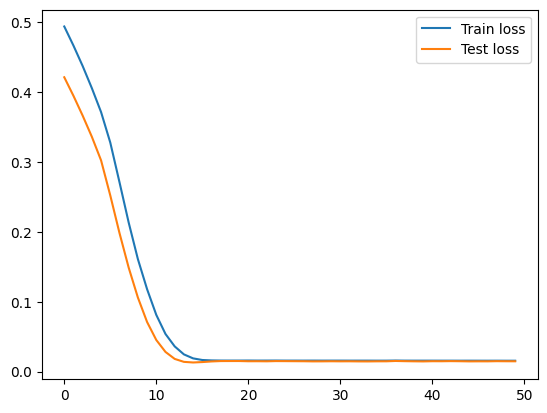

In [26]:
# Check NUH model train vs test loss
plt.plot(nuh_history2.history['loss'], label='Train loss')
plt.plot(nuh_history2.history['val_loss'], label='Test loss')
plt.legend();

We see that both train and test loss converge before 50 epochs. We can interpret that our model has been optimised as the train and test losses are minimised and converged at 50 epochs.

### Plot predictions
___

In [27]:
length=10
'''
Generating predictions
'''
# Generating prediction values from model
pred = nuh_model2.predict(test_sequences2)

# Undoing minmaxscaler on the predicted values
pred_it = y_scaler.inverse_transform(pred)

# Creating dataframe for predicted values
pred_df = pd.DataFrame(pred_it, columns=['predicted'])

# Set the pred values index to the indexes pertaining to the test values
pred_df.index = range(len(y_train2)+length, len(nuhdf))

# Appending the predicted values to the original dataframe so we can plot it against time
df_plot = df.reset_index().join(pred_df).set_index('date')



2024-02-08 22:56:37.803782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-08 22:56:37.998685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-08 22:56:37.999572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

3/3 [==============================] - 0s 2ms/step


2024-02-08 22:56:38.108557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-08 22:56:38.109632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-08 22:56:38.110354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

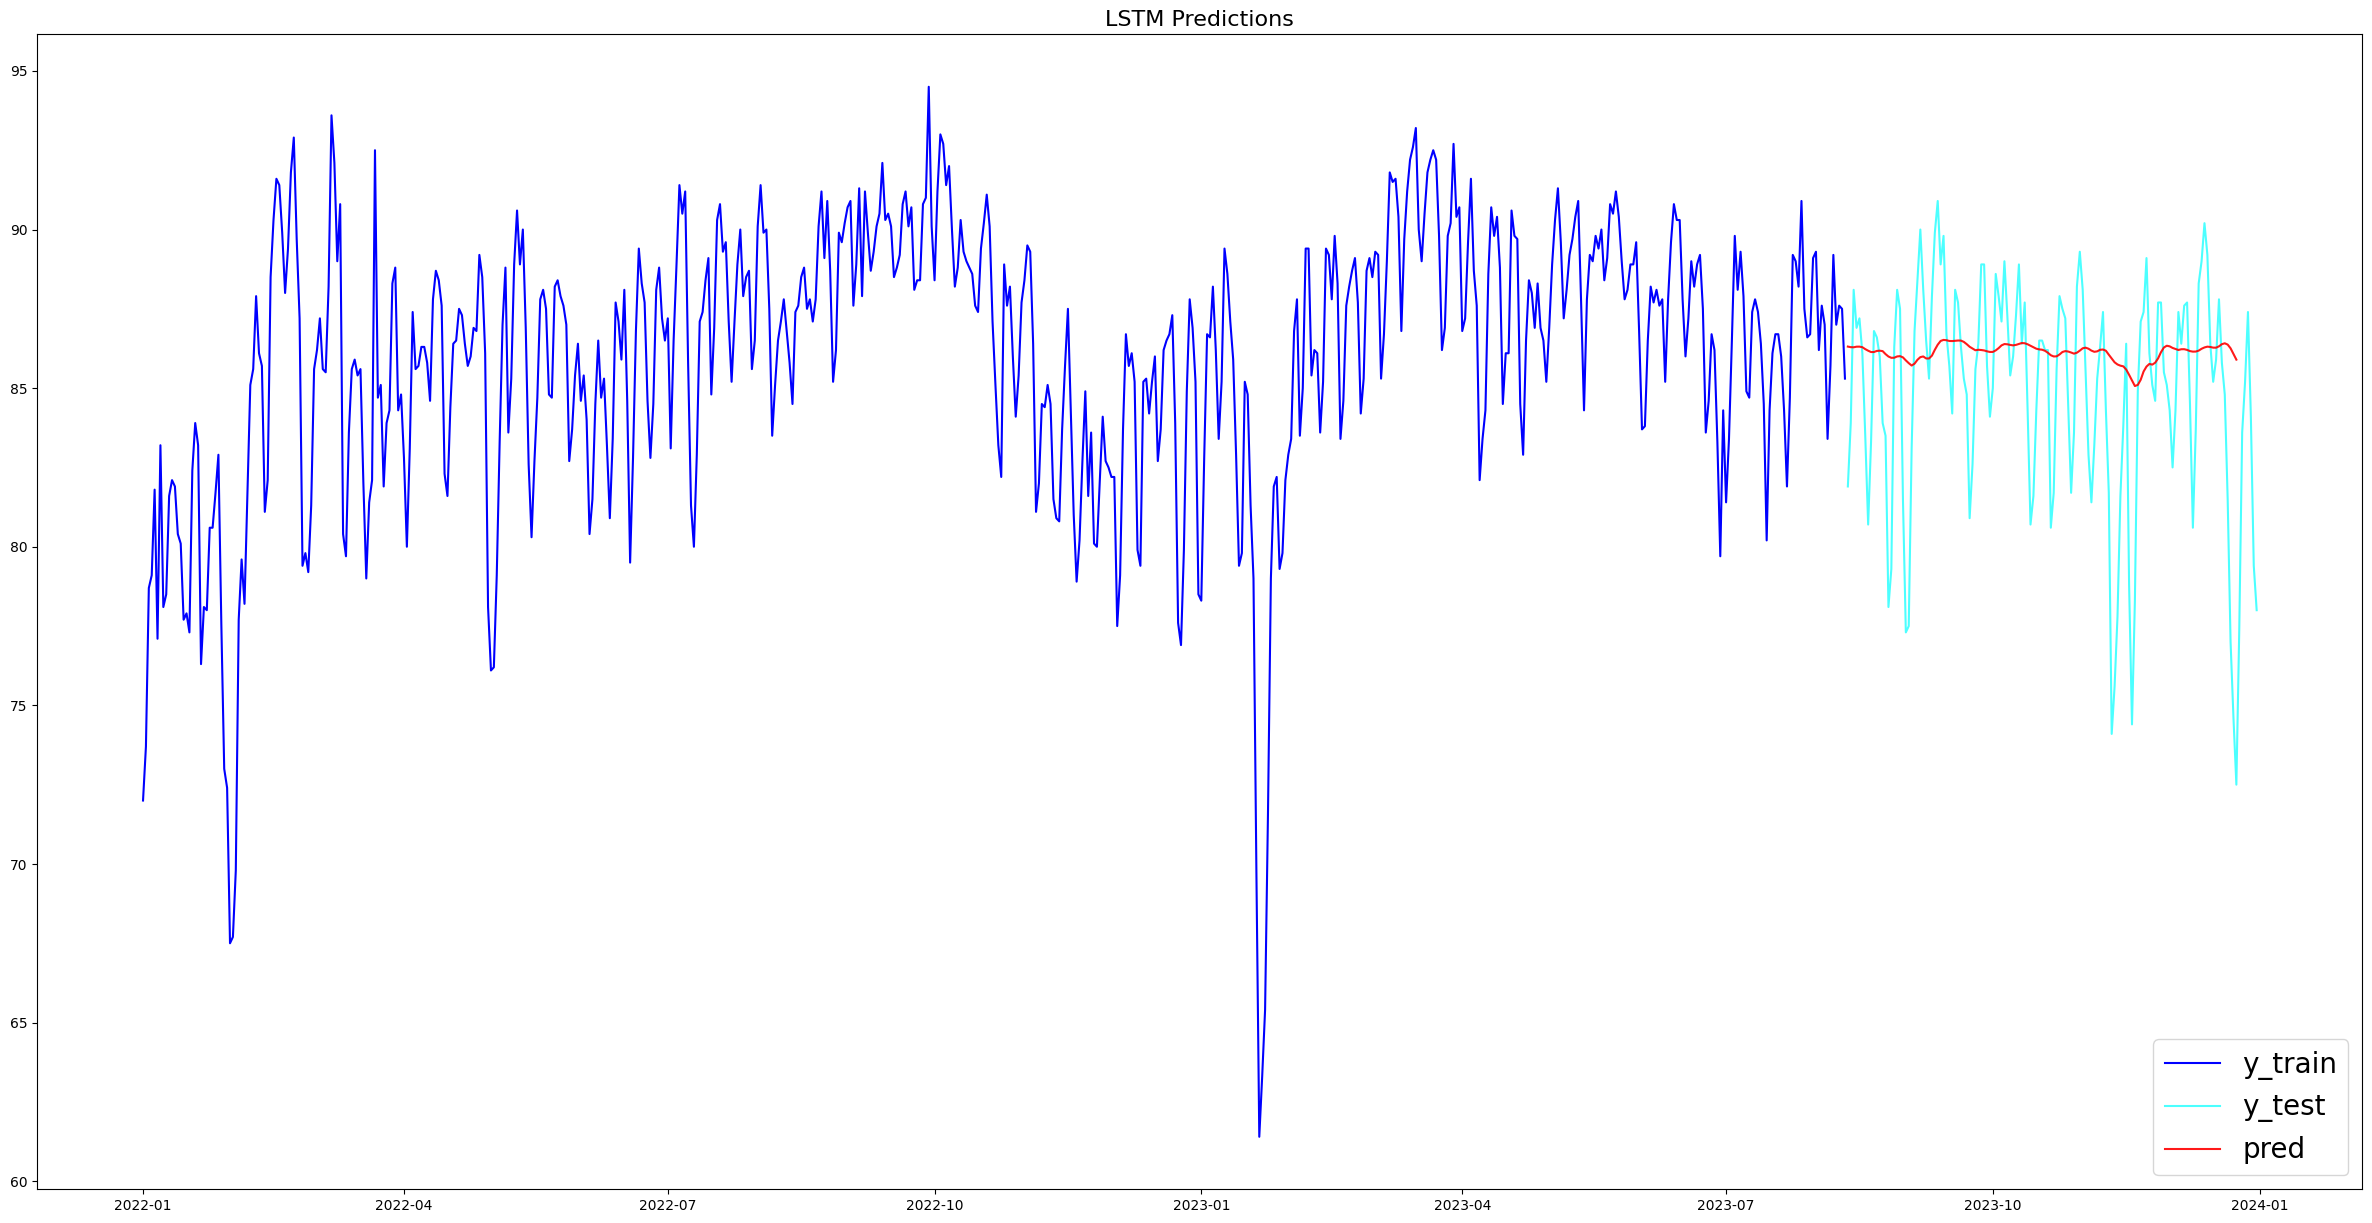

In [28]:
'''
Plotting graphs
'''
plt.figure(figsize=(30,15))

# Plot training data
plt.plot(df_plot['nuh'][:len(y_train2)+length], color='blue', label='y_train')

# Plot testing data
plt.plot(df_plot['nuh'][len(y_train2)+length:], color='cyan', label='y_test', alpha = 0.7)

# Plot predicted test values.
plt.plot(df_plot['predicted'], color='red', label='pred', alpha = 0.9)

plt.title(label = 'LSTM Predictions', fontsize=16)
plt.legend(fontsize = 20, loc = 'lower right');

As seen in the plot above, our autoregressive LSTM model appears to perform well on the unseen testing data. However, we acknowledge that this model will face similar issues as the SARIMA model, where predictions beyond the near future may not be as accurate due to unstability when extrapolated further in time.

### Conclusions and future work
___

The deep learning model (LSTM RNN) shows the greatest promise as a production algorithm for our BOR time series predictions. Despite the limitations around public-available statistics and the length of post-Covid BOR data, it shows a strong predictive ability on unseen data, with minimal requirement for supplementary features.

Upon commissioning, future work for the modeling could include **hospital data** to be supplied by NUH, such as:
- Emergency Department (ED) admissions data
- Length of stay data for different patient types and disease mix
- Discharge rates and patterns
- Readmission rates for specific conditions or patient groups
- Specific changes in work processes or innovations that could have had an impact patient care efficiency

One potential area of exploration is developing individual SARIMA for each predictive feature, before feeding these features to an overarching SARIMAX/LSTM model. This would allow us to extrapolate these models based on prior data, reducing reliance on current data.


### Performing predictions for future dates
___

As part of our project goals, we will use our LSTM model to perform predictions for bed occupancy beyond 2023. The following steps were performed to run our predictions and prepare the predicted values for our Streamlit widget.

In [29]:
''' Define function to perform prediction based on prior 10 rows'''
# def pred10(df, start, stop=1000):
#     arr_tf = x_scaler.transform(np.array(df.loc[start:stop]))
#     arr10 = np.expand_dims(arr_tf, axis=0)
#     pred = nuh_model2.predict(arr10, verbose=0)
#     return y_scaler.inverse_transform(pred)

' Define function to perform prediction based on prior 10 rows'

In [30]:
''' Define function to append predictions to the base dataframe'''
# def app_pred(df, pred):
#     df.loc[len(df)] = pd.Series(dtype='float64')
#     df.loc[len(df)-1][5] = pred
#     for colm in [6,7]:
#         df.loc[len(df)-1][colm] = df.loc[len(df)-colm][7]

' Define function to append predictions to the base dataframe'

We initialise the base dataframe for our future predictions below. This is necessary as our first prediction will be made using the prior 10 datapoints (as defined by the length=10 at the modelling step).

In [31]:
'''
Initialise base dataframe for predicted values
1. Extract last 10 rows of nuhdf
2. Drop column 0 (the target variable)
3. Reset index to integer (from datetime)
'''
# base_df = nuhdf.tail(10).drop(columns=0).reset_index(drop=True)
# base_df

'\nInitialise base dataframe for predicted values\n1. Extract last 10 rows of nuhdf\n2. Drop column 0 (the target variable)\n3. Reset index to integer (from datetime)\n'

In [32]:
'''Predict for 150 days (approximately till May)'''
# length=10
# day=150
# for x in range (day):
#     app_pred(base_df, pred10(base_df,x,x+length-1))

'Predict for 150 days (approximately till May)'

In [33]:
'''Further dataframe manipulations to prepare for plotting and export'''

# base_df = base_df.loc[21:].reset_index(drop=True)

# base_df['date']=pd.DataFrame([pd.to_datetime('1/1/2024') + timedelta(days=x) for x in range(day)])

# base_df = base_df.set_index('date')

'Further dataframe manipulations to prepare for plotting and export'

In [34]:
'''
Plotting graphs
'''
# plt.figure(figsize=(30,15))

# # Plot training data
# plt.plot(nuhdf[0][:len(y_train)+10], color='blue', label='y_train')

# # Plot testing data
# plt.plot(nuhdf[0][len(y_train)+10:], color='cyan', label='y_test', alpha = 0.7)

# # Plot predicted test values.
# plt.plot(base_df[5], color='red', label='pred', alpha = 0.9)

# plt.plot(test, color='red', label='pred', alpha = 0.9)

# plt.title(label = 'LSTM Predictions', fontsize=16)
# plt.legend(fontsize = 20, loc = 'lower right');


'\nPlotting graphs\n'

In [35]:
'''Code run to export model outputs to txt file, for the streamlit widget'''

# import json

# base_df.index=base_df.index.format()

# with open('dict.txt', 'w') as fp:
#     json.dump(pd.DataFrame(base_df[5]).to_dict(), fp)

'Code run to export model outputs to txt file, for the streamlit widget'